In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np


import wrangle as w
import explore as ex
import model as m
import evaluate as e

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.feature_selection import f_regression 
from math import sqrt

#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import r2_score

# Project Description
Zillow is a real estate marketplace company. The Zillow dataset is utilized in this project to find drivers for property value for single family properties. 

# Project Goal

* Discover drivers of property value in the Zillow dataset. 
* Use drivers to develop a machine learning model to predict the property value for a single family property.
* Property value is defined as an estimated value for a property.
* This information could be used to further our understanding of which elements contribute to the value of a property.

# Initial Thoughts

My initial hypothesis is that drivers of churn will be elements such as 'area_sqft', 'bathrooms', 'bedroom', 'fips', 'year'.

# Acquire
* Aquire dataset from Codeup database
* It contained 52442 rows and 7 columns before cleaning
* Each row represents a property at Zillow
* Each column represents a feature of those properties

# Prepare
- Prepare Actions:
    * Filtered columns that did not contain useful information
    * Renamed columns to promote readability
    * Checked for nulls in the data. The following columns contained nulls:
        - 'year' (116 nulls), these rows were dropped  
        - 'area_sqft' (82 nulls), these rows were dropped  
        - 'property_value' (1 null), these rows were dropped  
    * Checked that column data types were appropriate
    * Added full_bath column, which divides the type of bathrooms into homes with only full bathrooms and half               bathrooms and including one home that has a three-quarters bath.
    * Encoded categorical variables
    * Split data into train, validate and test (approx. 60/20/20), stratifying on 'churn'
    * Outliers have been removed for the iteration of the project, based on if they fell outside the 4 standard             deviation

# Data Dictionary 
| Feature | Definition |
|:--------|:-----------|
|Property Value (Target)| Value of a single family property|
|Area SQFT| The calculated finished square footage|
|Bathrooms| The number of bathrooms, (half baths: .5 & three-quarters bath: .75|
|Bedroom| 0 (No) or 1 (Yes), The number of bedrooms|
|Year| The year the home was built|
|Full Bath| 0 (No) or 1 (Yes), The home has only full bathrooms|
|Fips| 6037: "LA", 6059: "Orange", 6111: "Ventura"|
|Orange| 0 (No) or 1 (Yes), The home has is located in Orange county|
|Ventura| 0 (No) or 1 (Yes), The home has is located in Ventura county|

In [2]:
# retrieve the data from database or directory 
df = w.get_data()

In [3]:
# clean data, remove nulls, outliers and rename columns
df = w.clean_zillow()

697 outliers removed from property_value.
792 outliers removed from area_sqft.
658 outliers removed from bathrooms.
469 outliers removed from bedroom.
0 outliers removed from pool.
25 outliers removed from year.
0 outliers removed from full_bath.

Total of 2641 outliers removed.


In [4]:
# split the data into train, validate, test
train, validate, test = w.split_data(df)

# Summarize df 

In [5]:
# overview of data
train.head()

,property_value,area_sqft,bathrooms,bedroom,pool,fips,year,full_bath,orange,ventura
32810,143239.0,1338.0,1.0,2.0,0.0,LA,1953.0,1,0,0
26217,353024.0,1110.0,2.0,3.0,0.0,Ventura,1962.0,1,0,1
13781,709340.0,1560.0,2.0,3.0,0.0,Orange,1965.0,1,1,0
25812,303031.0,1168.0,2.5,2.0,0.0,Orange,1977.0,0,1,0
12771,275213.0,1356.0,2.0,2.0,1.0,LA,1959.0,1,0,0


# Explore

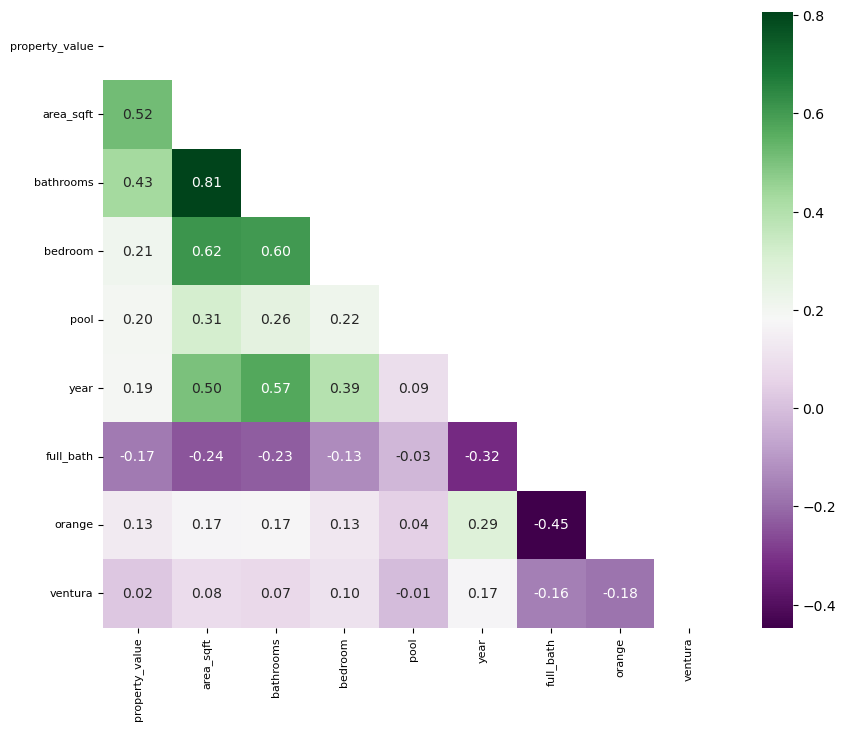

In [6]:
# Increase the figure size to accommodate the heatmap
plt.figure(figsize=(10, 8))
# Correlation heat map
sns.heatmap(train.corr(method='pearson'), cmap='PRGn', annot=True, fmt=".2f",
            mask=np.triu(train.corr(method='pearson')))
# Adjust the font size of the annotations
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
# Show the plot
plt.show()

## Is having 1 bathroom worse for property value than having 2 bedrooms?

In [7]:
null_hypothesis_1 = "The average property value for 1 bathroom homes is less than or equal to the average property value for 2 bedroom homes"
alternate_hypothesis_1 =  "The average property value for 1 bathroom homes is greater than the average property value for 2 bedroom homes"

In [8]:
alpha = 0.05
avg_one_bath =  train[train.bathrooms == 1].property_value
avg_two_bed = train[train.bedroom == 2].property_value

In [9]:
graph_title="example"
feature_Q1 = "bathrooms"
target = "property_value"

feature_Q2 = "bedroom"

**I will use an Indenpendent T-Test (1-tailed), to investigate whether having 1 bathroom is worse for property value than having 2 bedrooms**

* I will use a confidence interval of 95%
* The alpha is .05

In [10]:
ex.ind_test(avg_one_bath, avg_two_bed, null_hypothesis_1, alternate_hypothesis_1)


        Fail to reject the null: Insufficient evidence
        
 p-value: 7.902068766156978e-31 , t: -11.58541454497035


**We failed the reject the null hypothesis, it is not likely that that the number of bathrooms will be a useful feature to model on.**

## Does having a half bath better for property value than a full bath ?

In [11]:
null_hypothesis_2 = "The average property value for homes that have half bathrooms is less than or equal to the average property value for homes with full bathrooms"
alternate_hypothesis_2 =  "The average property value for homes that have half bathrooms is greater than the average property value for homes with full bathrooms"

In [12]:
avg_full_bath  = train[train.full_bath == 1].property_value
avg_half_bath = train[train.full_bath == 0].property_value

In [13]:
create_barplot(train, "full_bath", "property_value")

NameError: name 'create_barplot' is not defined

In [ ]:
ex.ind_test(avg_half_bath, avg_full_bath, null_hypothesis_2, alternate_hypothesis_2)

**We rejected the null hypothesis, therfore, we have evidence to support that if a home has half bathrooms has a greater property value. Based on this, I believe that using the 'full_bath' feature in modeling will likely have a small positive impact on the model's accuracy.**

## Does area sqft affect property value ?

In [ ]:
null_hypothesis_3 = "There is no linear correlation between the area_sqft and property value."
alternate_hypothesis_3 =  "There is a linear correlation between the area_sqft and property value."

In [ ]:
ex.create_relplot(x_var="area_sqft", y_var="property_value", df=train, title="Relationship Between Area and Property Value")

**There is a positive correlation that area sqft does affect property value. Based on this, I believe that using the 'area_sqft' feature in modeling will likely have a small positive impact on the model's accuracy.**

## Is a pool better for property value?

In [ ]:
null_hypothesis_4 = "The average property value for homes with pools is less than or equal to the average property value for homes without pools"
alternate_hypothesis_4 =  "The average property value for homes with pools is greater than the average property value for homes without pools"

In [ ]:
yes_pool  = train[train.pool == 1].property_value
no_pool = train[train.pool == 0].property_value

In [14]:
def create_barplot(df, x_var, y_var):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x_var, y=y_var, data=df)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'Barplot of {y_var} by {x_var}')
    plt.show()

In [ ]:
create_barplot(train, "pool", "property_value")

In [ ]:
ex.ind_test(yes_pool, no_pool, null_hypothesis_4, alternate_hypothesis_4)

**We rejected the null hypothesis, therfore, we have evidence to support that homes with pools have a greater property value, than homes without a pool. Based on this, I believe that using the 'pool' feature in modeling will likely have a small positive impact on the model's accuracy.**

## Is the average area  for properties in orange county greater than the overall average area?

In [ ]:
null_hypothesis_3 = "The average property value for homes in Orange county is less than or equal to the average property value in other counties"
alternate_hypothesis_3 =  "The average property value for homes in Orange county is greater than the average property value in other counties"

In [ ]:
orange_sample = train[train.fips == 'Orange'].property_value
overall_mean = train.property_value.mean()

In [ ]:
create_barplot(train, "fips", "property_value")

In [ ]:
ex.one_test(orange_sample, overall_mean, null_hypothesis_3, alternate_hypothesis_3)

**We rejected the null hypothesis, therfore, we have evidence to support that the average property value for homes located in Orange county is greater than the average property value in other counties. Based on this, I believe that using the 'Orange' feature in modeling will likely have a small positive impact on the model's accuracy.**

# Exploration Summary
* "Automatic Payment" was found to be a driver of "Churn", Customers' with 'Automatic Payment' churned less than those who didn't have 'Automatic Payment'.
* "Paperless Billing" was found to be a driver of "Churn", customers' with 'Paperless Billing' churned more than those who didn't have 'Paperless Billing'.
* "Partner" was found to be a driver of "Churn",  customers' with 'Partners' churned less than those who didn't.
* "Dependents" was found to be a driver of "Churn", customers' with 'Dependents' churned less than those who didn't.
* "Gender" was not found to be a driver of "Churn"
* "Tenure" was found to be a driver of "Churn", 'Tenure' of customers who 'Churn' is not equal to that of those who don't 'Churn'

# Features continuing to modeling

* "Automatic Payment" was found to be a driver of "Churn" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Paperless Billing" was found to be a driver of "Churn" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Partner" was found to be a driver of "Churn" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Dependents" was found to be a driver of "Churn" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Tenure" was found to be a driver of "Churn" (small difference in churn percentage, but relationship to churn is statistically significant)

# Features not continuing to modeling
* "Gender" was found to be a driver of "Churn"  (There is no evidence that "Gender" is a driver of churn)

# Modeling

* My evaluation metric will use RMSE and R2.

* The average property value is set as the baseline [rmse: 320706.78, r2: 0.00], and will continue to use for this project.
* I will be evaluating models developed using three different model types and various hyperparameter configurations.
* Models will be evaluated on train and validate data.
* The model that performs the best will then be evaluated on test data.

In [27]:
# features and the target variable
features = ['area_sqft', 'bathrooms', 'bedroom', 'year', 'pool', 'full_bath','orange', 'ventura']
target = "property_value"

In [28]:
# split the train, validate, test into x and y 
x_train, x_validate, x_test  = train[features], validate[features], test[features]
y_train, y_validate, y_test = train[target], validate[target], test[target]

In [29]:
# scaling the x datasets
x_train_scaled, x_validate_scaled, x_test_scaled = w.mm_scale(x_train, x_validate, x_test)

In [30]:
# creating and adding the baseline
baseline = y_train.mean()
baseline_array = np.repeat(baseline, len(train))
rmse, r2 = m.metrics_reg(y_train, baseline_array)

# metrics dataframe
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,369171.417182,0.0


## LinearRegression (OLS)

In [31]:
x_train_scaled

,area_sqft,bathrooms,bedroom,year,pool,full_bath,orange,ventura
0,0.270159,0.222222,0.25,0.479339,0.0,1.0,0.0,0.0
1,0.218223,0.444444,0.50,0.553719,0.0,1.0,0.0,1.0
2,0.320729,0.444444,0.50,0.578512,0.0,1.0,1.0,0.0
3,0.231435,0.555556,0.25,0.677686,0.0,0.0,1.0,0.0
4,0.274260,0.444444,0.25,0.528926,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
29802,0.399317,0.444444,0.50,0.239669,0.0,1.0,0.0,0.0
29803,0.280182,0.444444,0.50,0.628099,0.0,1.0,0.0,1.0
29804,0.364009,0.444444,0.25,0.165289,0.0,1.0,0.0,0.0
29805,0.312301,0.444444,0.25,0.446281,0.0,1.0,0.0,0.0


In [32]:
# make the model, fit and use it on train and validate
ols_rmse, ols_r2 = m.ols_mod(x_train_scaled, x_validate_scaled, y_train, y_validate)
# add to metrics_reg
metrics_df.loc[1] = ['ols', ols_rmse, ols_r2]

##  LassoLars

In [33]:
lars_rmse, lars_r2 = m.lars_mod(x_train_scaled, x_validate_scaled, y_train, y_validate)
metrics_df.loc[2] = ['lars', lars_rmse, lars_r2]

## TweedieRegressor (GLM)

In [34]:
glm_rmse, glm_r2 = m.glm_mod(x_train_scaled, x_validate_scaled, y_train, y_validate)
metrics_df.loc[3] = ['glm', glm_rmse, glm_r2]

## Polynomial Regression

In [35]:
ploy_rmse, ploy_r2 = m.poly_mod(x_train_scaled, x_validate_scaled, x_test_scaled, y_train, y_validate)
metrics_df.loc[4] = ['poly', ploy_rmse, ploy_r2]

# Metrics for Models

In [36]:
metrics_df

,model,rmse,r2
0,baseline,369171.417182,0.000000
1,ols,306009.272027,0.311014
2,lars,306012.114382,0.311001
3,glm,306009.273118,0.311014
4,poly,296972.556968,0.351105


# Comparing Models
* All of the models preformed better than the baseline
* The best model overall was the Polynomial Regression which had the lowest RMSE and R2 
* I have chosen to move forward with the Polynomial Regression model.

# Polynomial Regression on Test

In [37]:
test_rmse, test_r2 = m.best_model(x_train_scaled, x_test_scaled, y_train, y_test)
metrics_df.loc[5] = ['final test', test_rmse, test_r2]

In [38]:
metrics_df

,model,rmse,r2
0,baseline,369171.417182,0.000000
1,ols,306009.272027,0.311014
2,lars,306012.114382,0.311001
3,glm,306009.273118,0.311014
4,poly,296972.556968,0.351105
5,final test,304738.388531,0.351256


# Conclusions

### Exploration
* "Automatic Payment" was found to be a driver of "Churn", customers' with auto pay set were not churning as often
* "Paperless Billing" was found to be a driver of "Churn",  customers' with paperless billing were churning more
* "Partner" was found to be a driver of "Churn", are more likely to churn if the customer does not have a partner
* "Dependents" was found to be a driver of "Churn", are more likely to churn if the customer does not have dependents
* "Tenure" was found to be a driver of "Churn", Customers' with low 'Tenure' churned more than those who had high 'Tenure
* "Gender" was not found to be a driver of "Churn"


### Modeling Takeaways 
The final model significantly outperformed the baseline. Polynomial Regression which had the lowest RMSE and highest R2.


### Recommendations
* To decrease the likelihood of customers churning offer a small incentive for new/current customers to initiate automatic payments.
* To decrease the likelihood of customers' with low tenure, dependents, or partners from churning, offer these selected customers discounted rates for longer contracts.

### Next Steps
* I would like to explore further into paperless billing and tenure, to explore other possible factors that contribute to the relationship.
* I would like to explore other features, such as monthly payments and internet service providers to find other driving factors. 